In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import product
from toolz import keymap, topk
from scipy.spatial.distance import jensenshannon
from aging.behavior.age_models import MODEL_OPTIONS, generate_pipeline, fit_model
from aging.plotting import format_plots, figure, legend, add_identity, COLORMAPS
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import ParameterGrid

format_plots()

In [2]:
MODEL_OPTIONS

{'linear': sklearn.linear_model._base.LinearRegression,
 'elastic': sklearn.linear_model._coordinate_descent.ElasticNet,
 'pls': sklearn.cross_decomposition._pls.PLSRegression,
 'svm': sklearn.svm._classes.SVR,
 'knn': sklearn.neighbors._regression.KNeighborsRegressor,
 'rf': sklearn.ensemble._forest.RandomForestRegressor,
 'gb': sklearn.ensemble._gb.GradientBoostingRegressor,
 'ada': sklearn.ensemble._weight_boosting.AdaBoostRegressor,
 'mlp': sklearn.neural_network._multilayer_perceptron.MLPRegressor}

In [3]:
keep_syllables = np.loadtxt(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
    dtype=int,
)

def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')
    return df


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    age_mapping = {
        93: 94,
        95: 94,
        97: 98,
        98: 98,
        102: 98,
        103: 105,
        105: 105,
        107: 105
    }

    df = df.reset_index(level='age')
    df['age'] = df['age'].map(age_mapping).fillna(df['age'])

    return df.set_index('age', append=True).reorder_levels(idx)


def fit_seq(mdl, X, y, mdl_type, sex, use_log, use_poly=False, params=None):
    pipeline = generate_pipeline(mdl(), use_poly, use_log)
    if params is not None:
        pipeline = pipeline.set_params(**params)
    r2s, y_pred = fit_model(pipeline, X, y, n_repeats=3)
    mae = median_absolute_error(y, y_pred)

    # make plot
    # fig = figure(1.5, 1.5)
    # ax = fig.gca()
    # ax.scatter(y, y_pred, c=y, cmap=COLORMAPS.ont_male if sex == 'm' else COLORMAPS.ont_female, s=15)
    # title = f"{mdl_type} R2: {np.max(r2s):0.2f}; MAE: {mae:0.1f} weeks"
    # if use_log:
    #     title += " - log"
    # if use_poly:
    #     title += " - poly feat."
    # ax.set(title=title, xlabel="Age (weeks)", ylabel="Pred age (weeks)")
    # add_identity(ax, ls='--', color='gray', zorder=-1)
    # plt.show()

    return mae, np.mean(r2s)

In [4]:
male_df = read_male_ontogeny(keep_syllables) + 1e-4
female_df = read_female_ontogeny(keep_syllables) + 1e-4
male_age = male_df.index.get_level_values('age')
female_age = female_df.index.get_level_values('age')

In [5]:
grids = {
    'pls': {
        'n_components': np.arange(2, 11, 2, dtype=int),
    },
    'gb': {
        'n_estimators': np.linspace(150, 500, 6, dtype=int),
        'max_depth': np.arange(2, 7),
    },
    'mlp': {
        'hidden_layer_sizes': [(100,), (200,), (30,), (150, 50)],
        'max_iter': [10_000],
        'max_fun': [100_000],
        'activation': ['relu', 'tanh'],
        'solver': ['lbfgs'],
    },
    'knn': {
        'metric': ['euclidean', 'cosine'],
        'weights': ['uniform', 'distance'],
        'n_neighbors': np.linspace(5, 40, 6, dtype=int),
    },
}

In [6]:
random.seed(0)

opt_output = []
prod_list = []

for model, grid in grids.items():
    grid = ParameterGrid(keymap(lambda k: 'model__' + k, grid))
    # prod_list.extend(product(('m', 'f'), (True, False), (True, False), grid, (model, )))
    prod_list.extend(product(('m',), (True, False), (False, ), grid, (model, )))

random.shuffle(prod_list)
for sex, use_log, use_poly, param_set, model in tqdm(prod_list):
    X = male_df if sex == 'm' else female_df
    y = male_age if sex == 'm' else female_age
    mae, r2 = fit_seq(MODEL_OPTIONS[model], X.to_numpy(), y.to_numpy(), model, sex, use_log, use_poly, params=param_set)
    opt_output.append({
        'model': model,
        'mae': mae,
        'r2': r2,
        'sex': sex,
        'log_xform': use_log,
        'poly_xform': use_poly,
        **keymap(lambda x: x.split('__')[1], param_set)
    })
    print(topk(5, opt_output, key=lambda x: -x['mae']), end='\r')

  0%|          | 0/134 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [7]:
opt_output = pd.DataFrame(opt_output)

In [12]:
opt_output.to_parquet('/n/scratch/users/w/wg41/2024-07-22-age-prediction-model-optimization.parquet')

<Axes: xlabel='r2', ylabel='mae'>

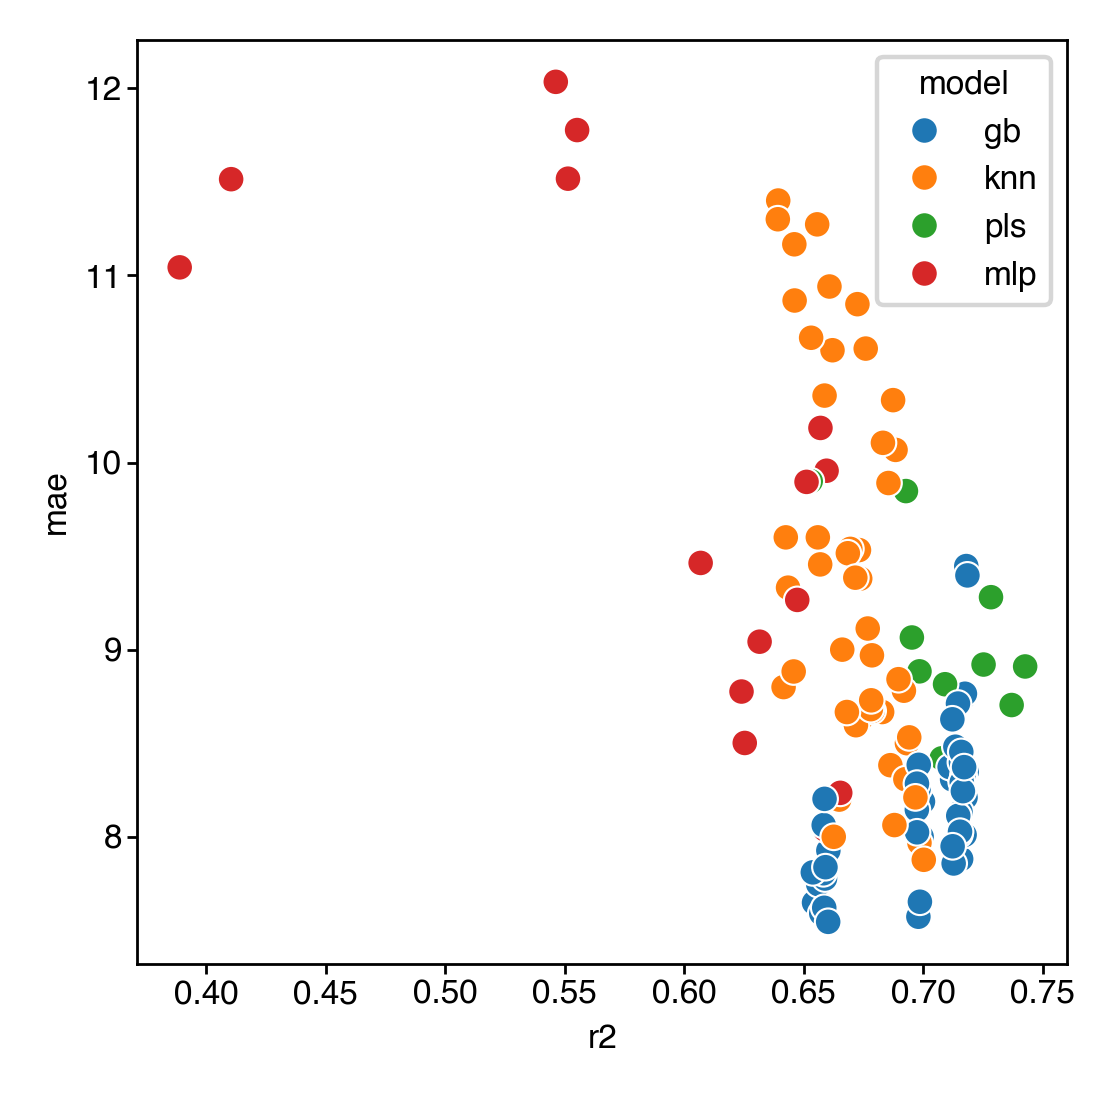

In [8]:
sns.scatterplot(data=opt_output, y='mae', x='r2', hue='model')

In [17]:
opt_output.sort_values(by='mae').head(60)

,model,mae,r2,sex,log_xform,poly_xform,max_depth,n_estimators,metric,n_neighbors,weights,n_components,activation,hidden_layer_sizes,max_fun,max_iter,solver
105,gb,7.545455,0.660281,m,True,False,6.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,gb,7.572719,0.698038,m,True,False,5.0,290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,gb,7.590678,0.657387,m,True,False,6.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,gb,7.620509,0.658634,m,True,False,6.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,gb,7.648112,0.654365,m,False,False,6.0,360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,gb,7.652803,0.698676,m,False,False,5.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,gb,7.746874,0.656109,m,True,False,6.0,360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,gb,7.776873,0.658956,m,True,False,6.0,430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,gb,7.805004,0.658286,m,False,False,6.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,gb,7.809845,0.653859,m,True,False,6.0,290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


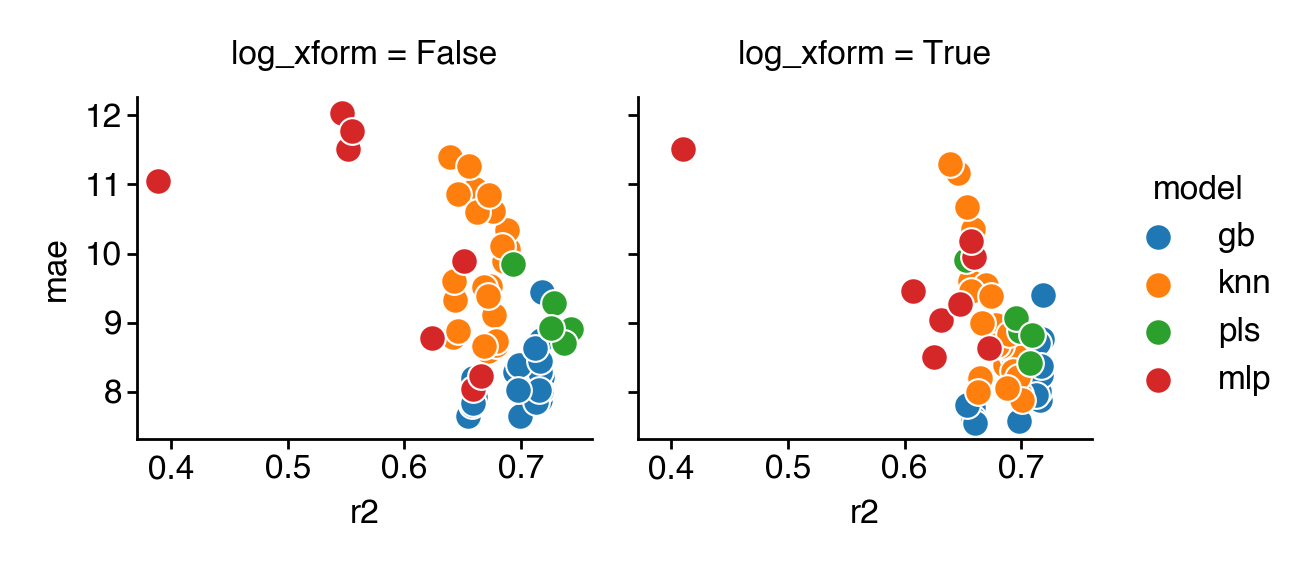

In [13]:
# fgrid = sns.FacetGrid(opt_output, row="poly_xform", col="log_xform", hue="model", height=1.4)
fgrid = sns.FacetGrid(opt_output, col="log_xform", hue="model", height=1.4)
fgrid.map(sns.scatterplot, "r2", "mae")
fgrid.add_legend()

## Version 2

In [45]:
grids = {
    'svm': {
        'kernel': ['linear', 'rbf'],
        'C': np.logspace(0, 3, 16),
    },
    'elastic': {
        'alpha': np.logspace(-3, 0, 10),
        'l1_ratio': np.linspace(0.1, 0.9, 17),
        'max_iter': [5_000],
    }
}

In [46]:
random.seed(0)

opt_output2 = []
prod_list = []

for model, grid in grids.items():
    grid = ParameterGrid(keymap(lambda k: 'model__' + k, grid))
    # prod_list.extend(product(('m', 'f'), (True, False), (True, False), grid, (model, )))
    prod_list.extend(product(('m',), (True, False), (False, ), grid, (model, )))

random.shuffle(prod_list)
for sex, use_log, use_poly, param_set, model in tqdm(prod_list):
    X = male_df if sex == 'm' else female_df
    y = male_age if sex == 'm' else female_age
    mae, r2 = fit_seq(MODEL_OPTIONS[model], X.to_numpy(), y.to_numpy(), model, sex, use_log, use_poly, params=param_set)
    opt_output2.append({
        'model': model,
        'mae': mae,
        'r2': r2,
        'sex': sex,
        'log_xform': use_log,
        'poly_xform': use_poly,
        **keymap(lambda x: x.split('__')[1], param_set)
    })
    print(topk(5, opt_output2, key=lambda x: -x['mae']), end='\r')

  0%|          | 0/404 [00:00<?, ?it/s]

In [47]:
opt_output2 = pd.DataFrame(opt_output2)

In [48]:
opt_output2.to_parquet('/n/scratch/users/w/wg41/2024-07-22-age-prediction-model-optimization-2.parquet')

In [49]:
opt_output2.sort_values(by='mae').head(30)

,model,mae,r2,sex,log_xform,poly_xform,alpha,l1_ratio,max_iter,C,kernel
248,svm,7.705408,0.737166,m,True,False,NaN,NaN,NaN,25.118864,rbf
266,svm,7.930093,0.730738,m,True,False,NaN,NaN,NaN,15.848932,rbf
304,svm,7.991662,0.731914,m,False,False,NaN,NaN,NaN,15.848932,rbf
159,elastic,8.082457,0.717971,m,True,False,0.464159,0.55,5000.0,NaN,NaN
115,elastic,8.089192,0.717451,m,True,False,0.464159,0.50,5000.0,NaN,NaN
89,elastic,8.119028,0.718531,m,True,False,0.464159,0.60,5000.0,NaN,NaN
396,elastic,8.180115,0.716951,m,True,False,0.464159,0.45,5000.0,NaN,NaN
64,elastic,8.194641,0.744992,m,False,False,0.464159,0.55,5000.0,NaN,NaN
114,elastic,8.198479,0.744178,m,False,False,0.464159,0.40,5000.0,NaN,NaN
18,elastic,8.205486,0.719670,m,True,False,0.464159,0.70,5000.0,NaN,NaN


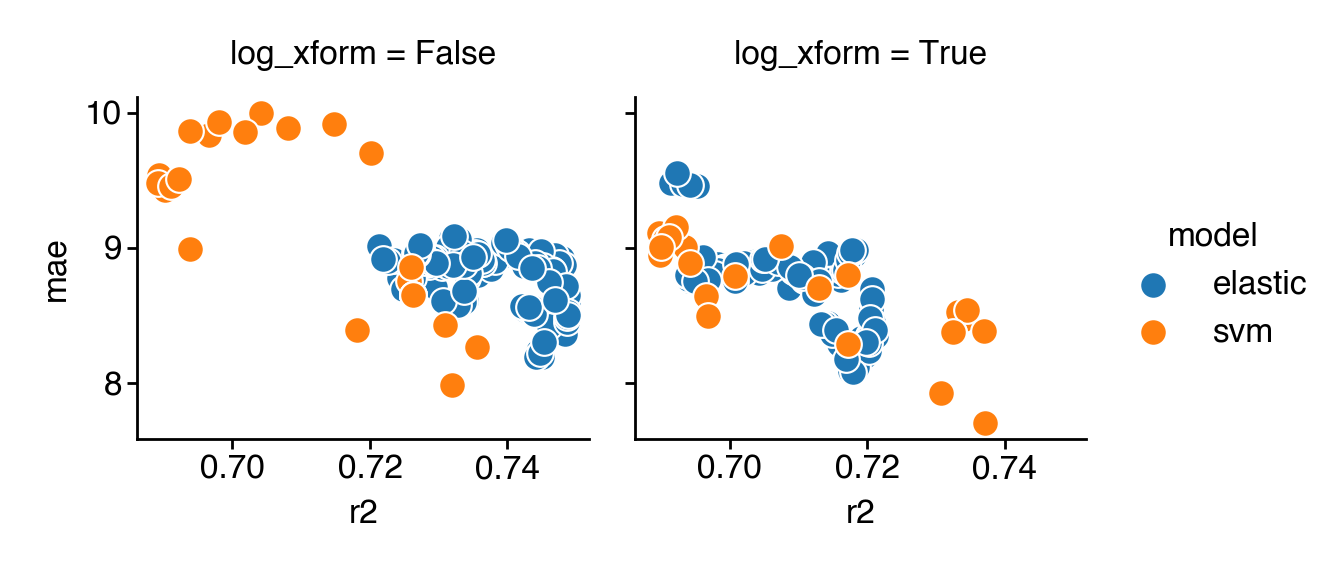

In [53]:
# fgrid = sns.FacetGrid(opt_output, row="poly_xform", col="log_xform", hue="model", height=1.4)
fgrid = sns.FacetGrid(opt_output2.query('r2 > 0.67'), col="log_xform", hue="model", height=1.4)
fgrid.map(sns.scatterplot, "r2", "mae")
fgrid.add_legend()